### EDA + Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data.csv")

# Let's see the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# And get a summary of its structure
print("\nDataset Info:")
df.info()

# Basic descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
print(df.describe())

First 5 rows of the dataset:
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural      

## Visualization
#### Categorial Visualization

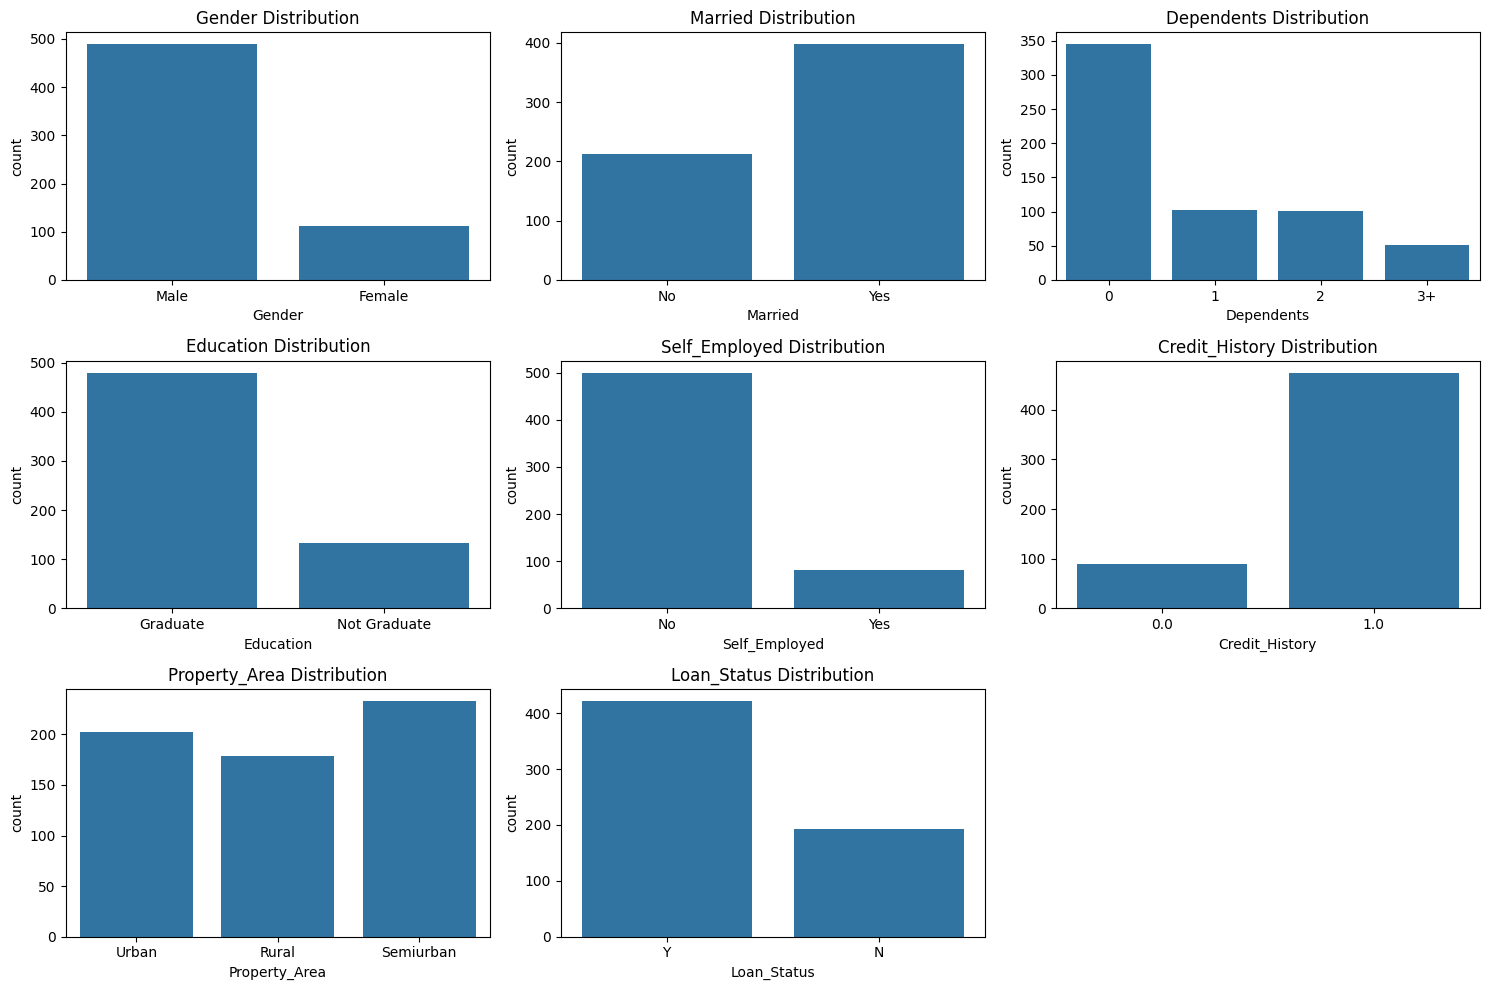

In [2]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
sns.countplot(data=df, x='Gender')
plt.title('Gender Distribution')

plt.subplot(3, 3, 2)
sns.countplot(data=df, x='Married')
plt.title('Married Distribution')

plt.subplot(3, 3, 3)
sns.countplot(data=df, x='Dependents')
plt.title('Dependents Distribution')

plt.subplot(3, 3, 4)
sns.countplot(data=df, x='Education')
plt.title('Education Distribution')

plt.subplot(3, 3, 5)
sns.countplot(data=df, x='Self_Employed')
plt.title('Self_Employed Distribution')

plt.subplot(3, 3, 6)
sns.countplot(data=df, x='Credit_History')
plt.title('Credit_History Distribution')

plt.subplot(3, 3, 7)
sns.countplot(data=df, x='Property_Area')
plt.title('Property_Area Distribution')

plt.subplot(3, 3, 8)
sns.countplot(data=df, x='Loan_Status')
plt.title('Loan_Status Distribution')

plt.tight_layout()
plt.show()

#### Numerical Features: Histograms and Box Plots

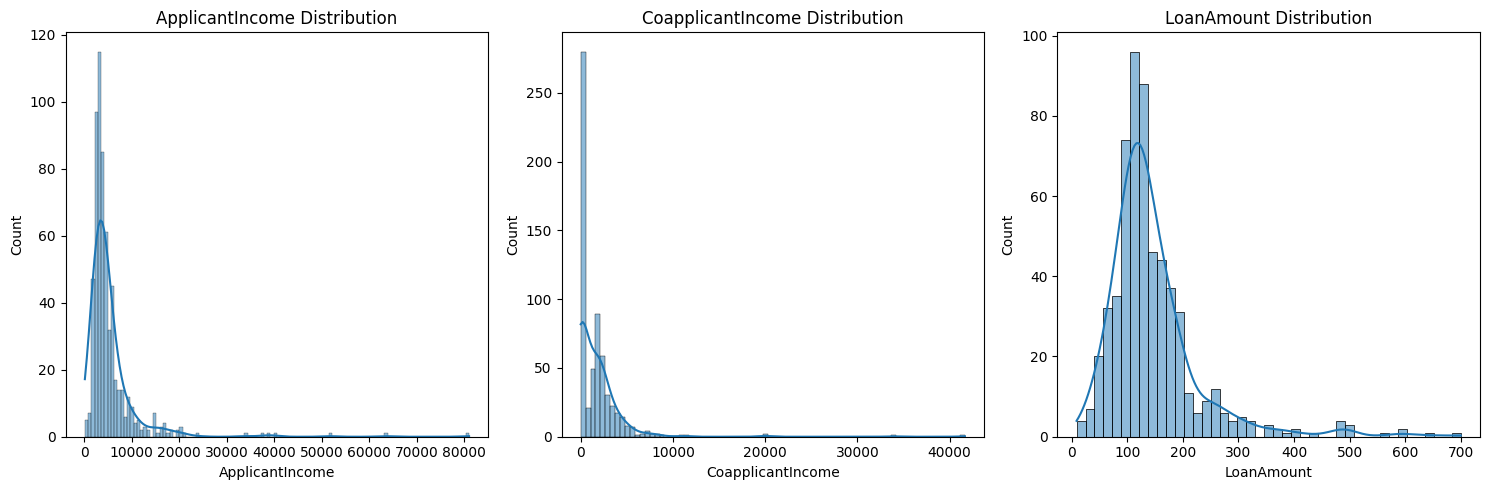

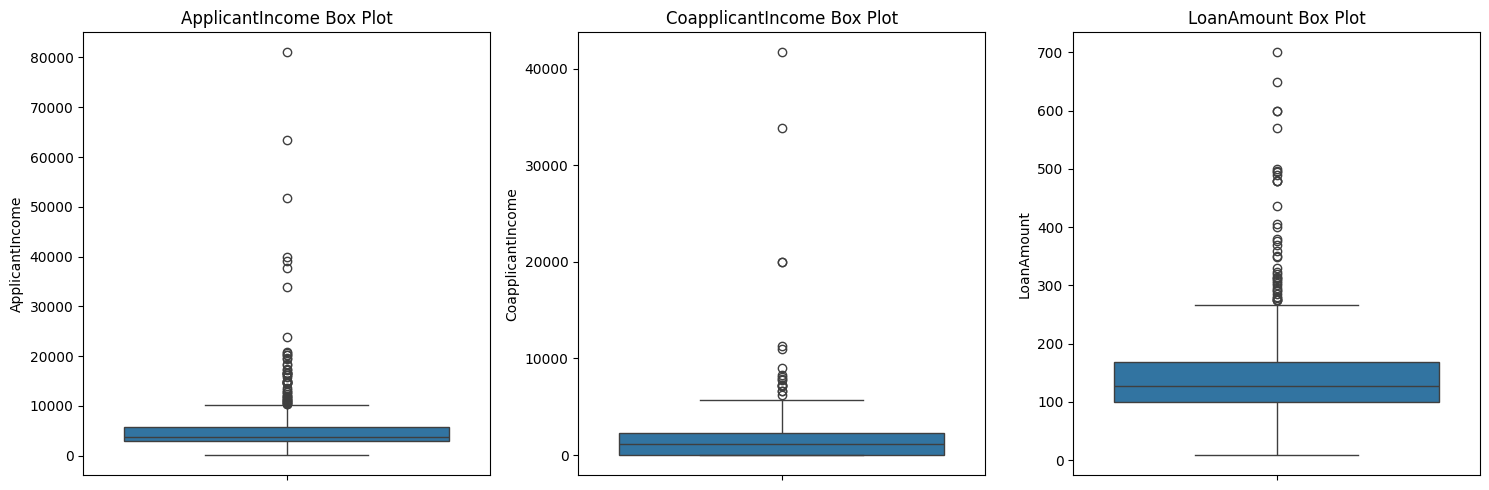

In [3]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['ApplicantIncome'], kde=True)
plt.title('ApplicantIncome Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df['CoapplicantIncome'], kde=True)
plt.title('CoapplicantIncome Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df['LoanAmount'], kde=True)
plt.title('LoanAmount Distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['ApplicantIncome'])
plt.title('ApplicantIncome Box Plot')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['CoapplicantIncome'])
plt.title('CoapplicantIncome Box Plot')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['LoanAmount'])
plt.title('LoanAmount Box Plot')
plt.tight_layout()
plt.show()

### Preprocessing

In [4]:
print("\nMissing Values Count:")
print(df.isnull().sum())

print("\nMissing Values Percentage:")
print((df.isnull().sum() / len(df)) * 100)


Missing Values Count:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Missing Values Percentage:
Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64


#### Handling Missing Values

In [5]:
# Impute missing values for categorical columns with the mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Impute missing values for numerical columns with the median (due to potential outliers)
for col in ['LoanAmount', 'Loan_Amount_Term']:
    df[col].fillna(df[col].median(), inplace=True)

print("\nMissing Values after Imputation:")
print(df.isnull().sum()) # Should all be 0 now!


Missing Values after Imputation:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


C:\Users\Shrijith\AppData\Local\Temp\ipykernel_1400\1784804194.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\Shrijith\AppData\Local\Temp\ipykernel_1400\1784804194.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

#### Handling Outliers

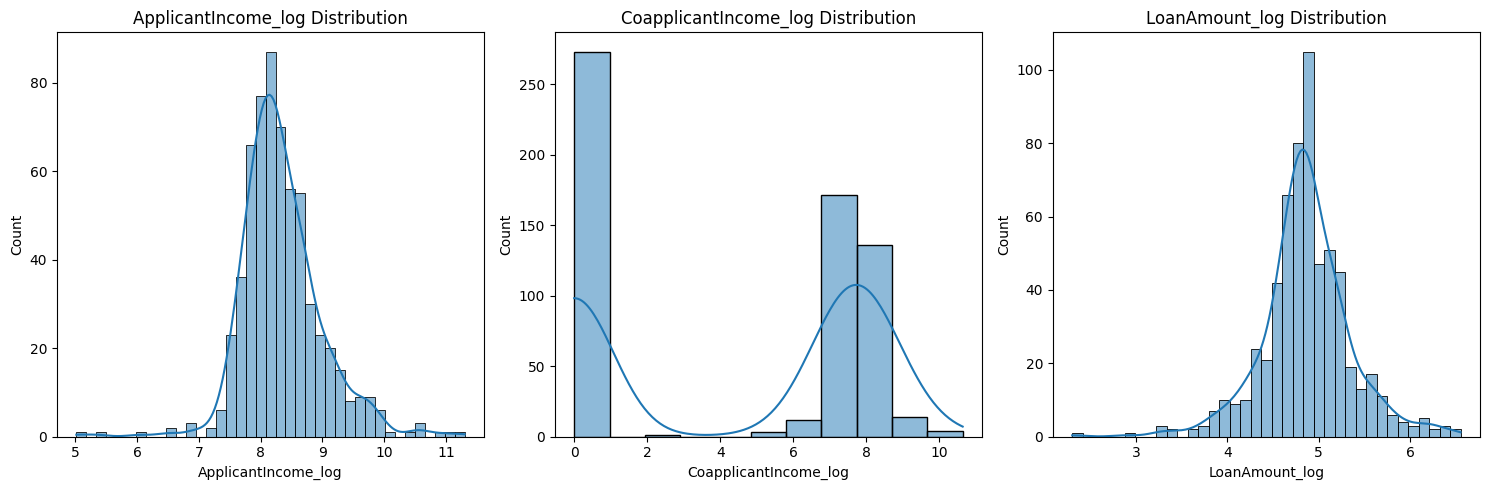

In [6]:
# Apply log transformation to skewed numerical features if needed
# This helps in reducing the impact of outliers and making the distribution more normal.
df['ApplicantIncome_log'] = np.log(df['ApplicantIncome'] + 1) # Add 1 to avoid log(0)
df['CoapplicantIncome_log'] = np.log(df['CoapplicantIncome'] + 1)
df['LoanAmount_log'] = np.log(df['LoanAmount'] + 1)

# You can also create a 'Total_Income' feature
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Total_Income_log'] = np.log(df['Total_Income'] + 1)

# Let's visualize the log-transformed distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['ApplicantIncome_log'], kde=True)
plt.title('ApplicantIncome_log Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df['CoapplicantIncome_log'], kde=True)
plt.title('CoapplicantIncome_log Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df['LoanAmount_log'], kde=True)
plt.title('LoanAmount_log Distribution')
plt.tight_layout()
plt.show()

####  Encoding Categorical Features

In [7]:
# Drop the original non-transformed income and loan amount columns
df = df.drop(columns=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_ID'])

# Handle 'Dependents' column: Convert '3+' to 3 and then to int
df['Dependents'] = df['Dependents'].replace('3+', '3').astype(int)

# One-hot encode categorical features
# Drop_first=True helps avoid multicollinearity (dummy variable trap)
df = pd.get_dummies(df, columns=['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)

# Encode the target variable 'Loan_Status'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Loan_Status'] = le.fit_transform(df['Loan_Status']) # 'N' becomes 0, 'Y' becomes 1

print("\nDataFrame after Encoding:")
print(df.head())
print("\nDataFrame Info after Preprocessing:")
df.info()


DataFrame after Encoding:
   Dependents  Loan_Amount_Term  Credit_History  Loan_Status  \
0           0             360.0             1.0            1   
1           1             360.0             1.0            0   
2           0             360.0             1.0            1   
3           0             360.0             1.0            1   
4           0             360.0             1.0            1   

   ApplicantIncome_log  CoapplicantIncome_log  LoanAmount_log  Total_Income  \
0             8.674197               0.000000        4.859812        5849.0   
1             8.430327               7.319202        4.859812        6091.0   
2             8.006701               0.000000        4.204693        3000.0   
3             7.857094               7.765993        4.795791        4941.0   
4             8.699681               0.000000        4.955827        6000.0   

   Total_Income_log  Gender_Male  Married_Yes  Education_Not Graduate  \
0          8.674197         True        

### Feature Engineering

In [8]:
# Let's add a Debt-to-Income Ratio.
# Using the log-transformed values might be more stable for ratios
df['Debt_to_Income_Ratio'] = df['LoanAmount_log'] / df['Total_Income_log']

# You can also consider a simpler one if you prefer, using original incomes/loan amounts
# df['Debt_to_Income_Ratio_orig'] = df['LoanAmount'] / df['Total_Income']

print("\nDataFrame after Feature Engineering (Debt_to_Income_Ratio added):")
print(df.head())


DataFrame after Feature Engineering (Debt_to_Income_Ratio added):
   Dependents  Loan_Amount_Term  Credit_History  Loan_Status  \
0           0             360.0             1.0            1   
1           1             360.0             1.0            0   
2           0             360.0             1.0            1   
3           0             360.0             1.0            1   
4           0             360.0             1.0            1   

   ApplicantIncome_log  CoapplicantIncome_log  LoanAmount_log  Total_Income  \
0             8.674197               0.000000        4.859812        5849.0   
1             8.430327               7.319202        4.859812        6091.0   
2             8.006701               0.000000        4.204693        3000.0   
3             7.857094               7.765993        4.795791        4941.0   
4             8.699681               0.000000        4.955827        6000.0   

   Total_Income_log  Gender_Male  Married_Yes  Education_Not Graduate  \


In [9]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = df.drop('Loan_Status', axis=1) # All columns except 'Loan_Status'
y = df['Loan_Status'] # Only the 'Loan_Status' column

# Split the data into training and testing sets
# test_size=0.2 means 20% of data for testing, 80% for training
# random_state ensures reproducibility (you get the same split every time you run it)
# stratify=y ensures that the proportion of 'Loan_Status' categories is the same in both train and test sets.
# This is crucial for imbalanced datasets, like our Loan_Status where one class might be more frequent.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Check the distribution of the target variable in training and test sets
print("\nLoan_Status distribution in y_train:")
print(y_train.value_counts(normalize=True))
print("\nLoan_Status distribution in y_test:")
print(y_test.value_counts(normalize=True))


Shape of X_train: (491, 15)
Shape of X_test: (123, 15)
Shape of y_train: (491,)
Shape of y_test: (123,)

Loan_Status distribution in y_train:
Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64

Loan_Status distribution in y_test:
Loan_Status
1    0.691057
0    0.308943
Name: proportion, dtype: float64


###  Model Selection and Training

Training Logistic Regression Model...
Model training complete!

Making predictions on the test set...
Predictions made!

--- Logistic Regression Model Evaluation ---
Training Accuracy: 0.7984
Test Accuracy: 0.8537

Confusion Matrix (Test Set):
[[21 17]
 [ 1 84]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



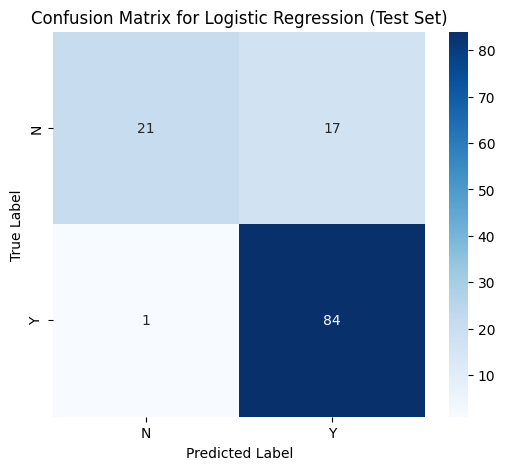


Logistic Regression Coefficients (Feature Importance):
                    Feature  Coefficient  Abs_Coefficient
2            Credit_History     3.009382         3.009382
12  Property_Area_Semiurban     0.662332         0.662332
9               Married_Yes     0.391042         0.391042
10   Education_Not Graduate    -0.390570         0.390570
7          Total_Income_log    -0.354709         0.354709
3       ApplicantIncome_log     0.198297         0.198297
8               Gender_Male    -0.180241         0.180241
5            LoanAmount_log    -0.168358         0.168358
13      Property_Area_Urban     0.129453         0.129453
0                Dependents     0.090296         0.090296
11        Self_Employed_Yes    -0.089851         0.089851
4     CoapplicantIncome_log     0.057777         0.057777
14     Debt_to_Income_Ratio    -0.032709         0.032709
1          Loan_Amount_Term    -0.000213         0.000213
6              Total_Income     0.000006         0.000006


In [10]:
## Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Initialize the Logistic Regression model
# We'll use a 'solver' that works well for typical datasets.
# 'random_state' ensures reproducibility for the model's internal randomness.
model_lr = LogisticRegression(random_state=42, solver='liblinear')

# 2. Train the model using our training data
# This is where the model "learns" the patterns between X_train and y_train
print("Training Logistic Regression Model...")
model_lr.fit(X_train, y_train)
print("Model training complete!")

# 3. Make predictions on the training set (to check for overfitting)
y_train_pred_lr = model_lr.predict(X_train)

# 4. Make predictions on the test set (this is the crucial one for evaluation)
print("\nMaking predictions on the test set...")
y_test_pred_lr = model_lr.predict(X_test)
print("Predictions made!")

# 5. Evaluate the model's performance
print("\n--- Logistic Regression Model Evaluation ---")

# Accuracy: The proportion of correctly classified instances
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
print(f"Training Accuracy: {train_accuracy_lr:.4f}")
print(f"Test Accuracy: {test_accuracy_lr:.4f}")

# Confusion Matrix: Helps visualize the types of correct and incorrect predictions
# True Positives (TP): Model predicted Y, actual was Y
# True Negatives (TN): Model predicted N, actual was N
# False Positives (FP): Model predicted Y, actual was N (Type I error) - Bad for bank (approves bad loan)
# False Negatives (FN): Model predicted N, actual was Y (Type II error) - Bad for bank (rejects good applicant)
print("\nConfusion Matrix (Test Set):")
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
print(cm_lr)

# A more detailed classification report: Precision, Recall, F1-Score
# Precision: Of all predicted positives, how many were actually positive? (TP / (TP + FP))
# Recall (Sensitivity): Of all actual positives, how many did we correctly identify? (TP / (TP + FN))
# F1-Score: Harmonic mean of Precision and Recall (balances both)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_lr))

# Visualizing the Confusion Matrix (makes it easier to read!)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_) # Assuming le is the LabelEncoder from earlier
plt.title('Confusion Matrix for Logistic Regression (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Quick check of coefficients (what features are most important for LR)
print("\nLogistic Regression Coefficients (Feature Importance):")
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model_lr.coef_[0]})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
print(feature_importance)


Training Decision Tree Model...
Model training complete!

--- Decision Tree Model Evaluation ---
Training Accuracy: 0.8371
Test Accuracy: 0.8537

Confusion Matrix (Test Set):
[[23 15]
 [ 3 82]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        38
           1       0.85      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123



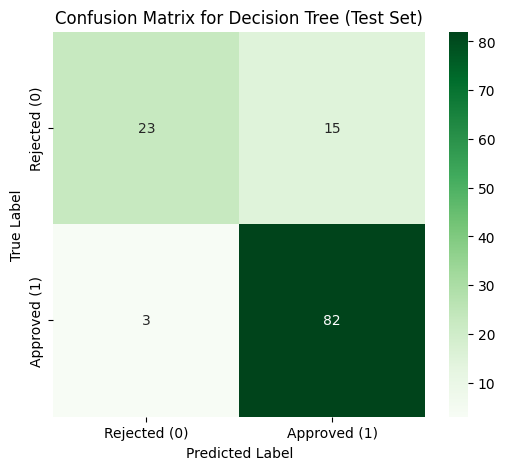

In [11]:
## Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize the Decision Tree model
# We'll set a max_depth to prevent severe overfitting for now
model_dt = DecisionTreeClassifier(random_state=42, max_depth=5) # Limiting depth to avoid too much overfitting

# 2. Train the model
print("\nTraining Decision Tree Model...")
model_dt.fit(X_train, y_train)
print("Model training complete!")

# 3. Make predictions
y_train_pred_dt = model_dt.predict(X_train)
y_test_pred_dt = model_dt.predict(X_test)

# 4. Evaluate the model's performance
print("\n--- Decision Tree Model Evaluation ---")
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
print(f"Training Accuracy: {train_accuracy_dt:.4f}")
print(f"Test Accuracy: {test_accuracy_dt:.4f}")

print("\nConfusion Matrix (Test Set):")
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
print(cm_dt)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_dt))

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Greens",
            xticklabels=['Rejected (0)', 'Approved (1)'], yticklabels=['Rejected (0)', 'Approved (1)'])
plt.title('Confusion Matrix for Decision Tree (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# You can also visualize the tree itself for better understanding (requires graphviz)
# from sklearn.tree import plot_tree
# plt.figure(figsize=(20, 15))
# plot_tree(model_dt, feature_names=X.columns, class_names=['Rejected', 'Approved'], filled=True, rounded=True)
# plt.title('Decision Tree Visualization')
# plt.show()


Training Random Forest Model...
Model training complete!

--- Random Forest Model Evaluation ---
Training Accuracy: 0.9470
Test Accuracy: 0.8699

Confusion Matrix (Test Set):
[[25 13]
 [ 3 82]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.66      0.76        38
           1       0.86      0.96      0.91        85

    accuracy                           0.87       123
   macro avg       0.88      0.81      0.83       123
weighted avg       0.87      0.87      0.86       123



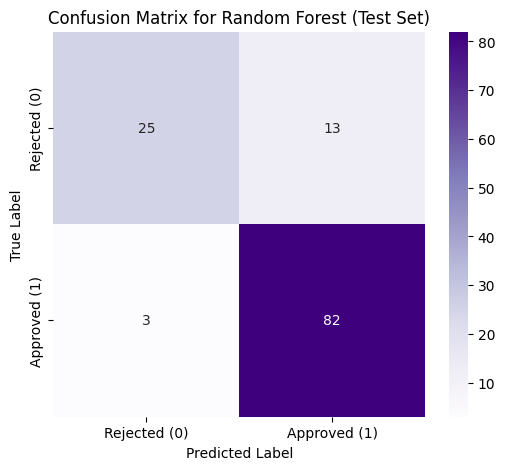


Random Forest Feature Importance:
                    Feature  Importance
2            Credit_History    0.275351
14     Debt_to_Income_Ratio    0.107474
6              Total_Income    0.104138
3       ApplicantIncome_log    0.100904
7          Total_Income_log    0.099686
5            LoanAmount_log    0.092768
4     CoapplicantIncome_log    0.067805
1          Loan_Amount_Term    0.031509
0                Dependents    0.030541
12  Property_Area_Semiurban    0.023313
9               Married_Yes    0.016126
10   Education_Not Graduate    0.015230
13      Property_Area_Urban    0.013158
11        Self_Employed_Yes    0.012002
8               Gender_Male    0.009996


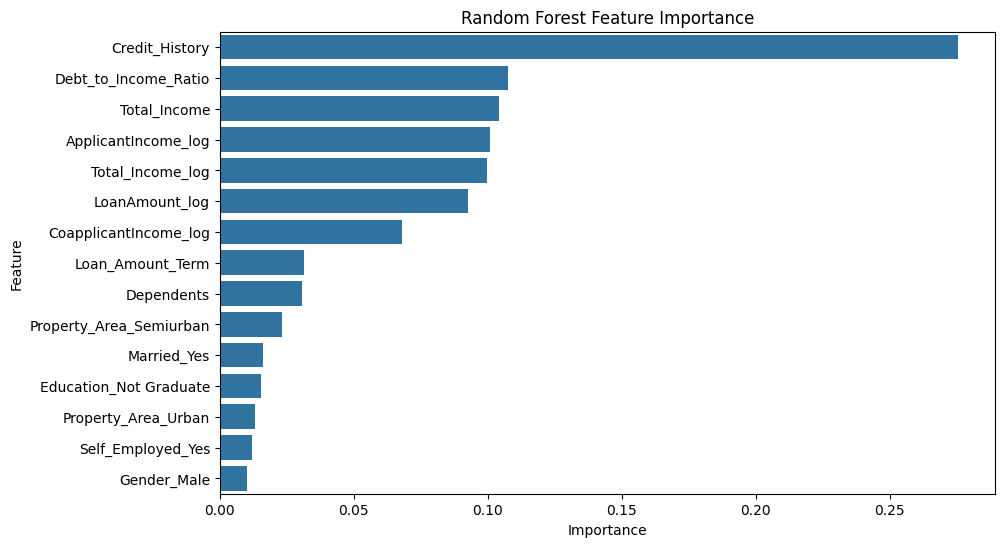

In [12]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Initialize the Random Forest model
# n_estimators: number of trees in the forest
# max_depth: maximum depth of each tree (can be left None for full growth, or limited)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10) # 100 trees, limited depth

# 2. Train the model
print("\nTraining Random Forest Model...")
model_rf.fit(X_train, y_train)
print("Model training complete!")

# 3. Make predictions
y_train_pred_rf = model_rf.predict(X_train)
y_test_pred_rf = model_rf.predict(X_test)

# 4. Evaluate the model's performance
print("\n--- Random Forest Model Evaluation ---")
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Training Accuracy: {train_accuracy_rf:.4f}")
print(f"Test Accuracy: {test_accuracy_rf:.4f}")

print("\nConfusion Matrix (Test Set):")
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print(cm_rf)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred_rf))

# Visualizing the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Purples",
            xticklabels=['Rejected (0)', 'Approved (1)'], yticklabels=['Rejected (0)', 'Approved (1)'])
plt.title('Confusion Matrix for Random Forest (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance for Random Forest
print("\nRandom Forest Feature Importance:")
feature_importances_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': model_rf.feature_importances_})
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)
print(feature_importances_rf)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_rf)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Highparameter Tuning- GridSearchCV


Starting GridSearchCV for Hyperparameter Tuning (this might take a while)...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
GridSearchCV complete!

Best Parameters found: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best F1-score found (on validation sets): 0.8716

--- Evaluating Tuned Random Forest Model on Test Set ---
Test Accuracy (Tuned RF): 0.8537

Confusion Matrix (Tuned RF - Test Set):
[[23 15]
 [ 3 82]]

Classification Report (Tuned RF - Test Set):
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        38
           1       0.85      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123



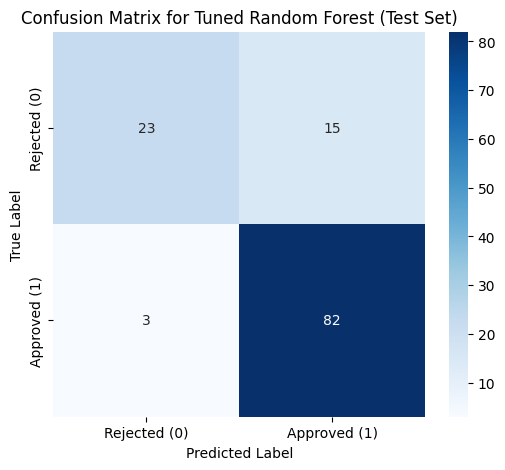


Feature Importance from Tuned Random Forest Model:
                    Feature  Importance
2            Credit_History    0.452390
6              Total_Income    0.087443
14     Debt_to_Income_Ratio    0.081546
3       ApplicantIncome_log    0.080014
7          Total_Income_log    0.079072
5            LoanAmount_log    0.060630
4     CoapplicantIncome_log    0.046781
1          Loan_Amount_Term    0.035404
12  Property_Area_Semiurban    0.029369
0                Dependents    0.015617
10   Education_Not Graduate    0.010115
9               Married_Yes    0.009505
11        Self_Employed_Yes    0.006115
8               Gender_Male    0.003890
13      Property_Area_Urban    0.002110


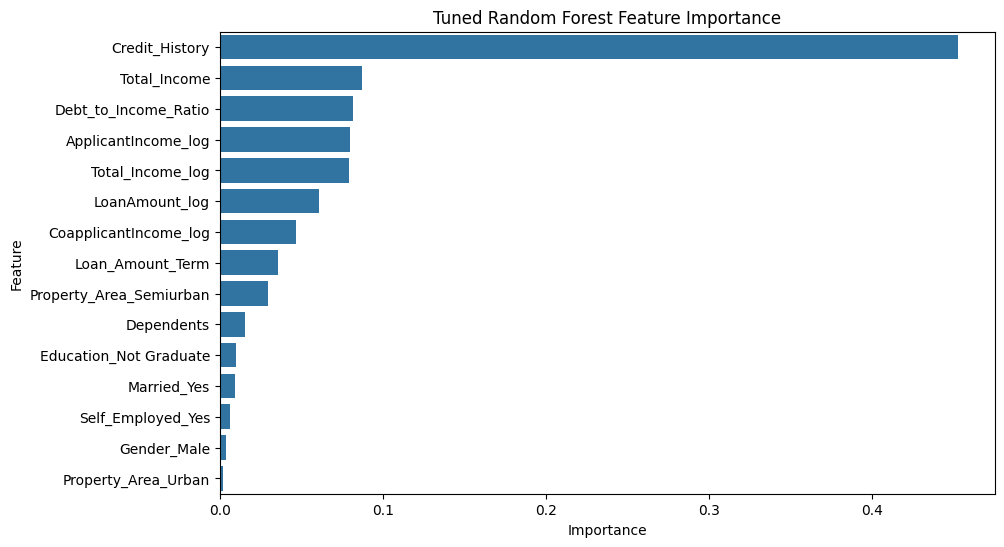

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 250, 500], # Number of trees
    'max_depth': [5, 10, 15, None], # Maximum depth of the tree (None means full depth)
    'min_samples_split': [2, 5, 10], # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],   # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'] # Number of features to consider for best split
}

# Initialize GridSearchCV
# estimator: our Random Forest model
# param_grid: the dictionary of parameters to search
# cv: number of folds for cross-validation (e.g., 5-fold cross-validation)
# scoring: the metric to optimize (e.g., 'accuracy', 'f1', 'roc_auc')
# n_jobs: number of CPU cores to use (-1 means use all available)
# verbose: verbosity mode (higher number for more messages)
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, # 5-fold cross-validation
                           scoring='f1', # Let's optimize for F1-score as it balances Precision and Recall
                           n_jobs=-1, # Use all available CPU cores
                           verbose=2) # Display progress messages

# Fit GridSearchCV to the training data
print("\nStarting GridSearchCV for Hyperparameter Tuning (this might take a while)...")
grid_search.fit(X_train, y_train)
print("GridSearchCV complete!")

# Get the best parameters and best score
print(f"\nBest Parameters found: {grid_search.best_params_}")
print(f"Best F1-score found (on validation sets): {grid_search.best_score_:.4f}")

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
print("\n--- Evaluating Tuned Random Forest Model on Test Set ---")
y_test_pred_tuned_rf = best_rf_model.predict(X_test)

tuned_rf_accuracy = accuracy_score(y_test, y_test_pred_tuned_rf)
tuned_rf_cm = confusion_matrix(y_test, y_test_pred_tuned_rf)
tuned_rf_report = classification_report(y_test, y_test_pred_tuned_rf)

print(f"Test Accuracy (Tuned RF): {tuned_rf_accuracy:.4f}")
print("\nConfusion Matrix (Tuned RF - Test Set):")
print(tuned_rf_cm)
print("\nClassification Report (Tuned RF - Test Set):")
print(tuned_rf_report)

# Visualizing the Confusion Matrix for the Tuned Model
plt.figure(figsize=(6, 5))
sns.heatmap(tuned_rf_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Rejected (0)', 'Approved (1)'], yticklabels=['Rejected (0)', 'Approved (1)'])
plt.title('Confusion Matrix for Tuned Random Forest (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature Importance from the Best Tuned Model
print("\nFeature Importance from Tuned Random Forest Model:")
feature_importances_tuned_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances_tuned_rf)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_tuned_rf)
plt.title('Tuned Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


ROC AUC Score (Tuned RF): 0.8613


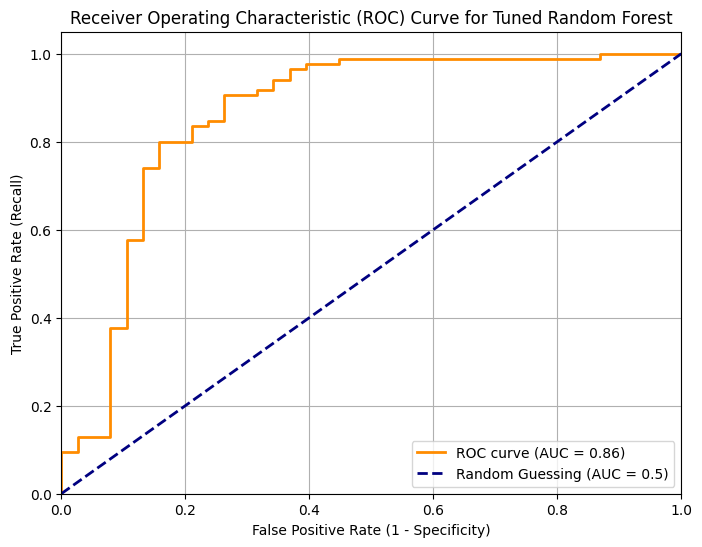

In [15]:
from sklearn.metrics import roc_curve, auc

# Get probability predictions for the positive class (Loan_Status = 1)
y_prob_tuned_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_tuned_rf)

# Calculate AUC
roc_auc = auc(fpr, tpr)

print(f"\nROC AUC Score (Tuned RF): {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Tuned Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [1]:
print("\n--- Model Evaluation Summary ---")
print(f"Logistic Regression Test Accuracy: {test_accuracy_lr:.4f}")


--- Model Evaluation Summary ---


NameError: name 'test_accuracy_lr' is not defined